In [1]:
# Validation of the steady-state simulation - Case 3: AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model
n_layers=5
n_kernels=200 # Number of kernels in convolutional network
kernel_size1=2
strides=1
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
val_rate=0.2
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [5]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha
aa_ = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa_[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]
    
aa = aa_ / np.max(alpha)

In [6]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [7]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [8]:
## Creating input dataset - mask
mask_dir = main_directory + '\\aeroCNN2Mask'
os.chdir(mask_dir)
mask_list = os.listdir(mask_dir)
mask_target = [file for file in mask_list if file.endswith('.csv')]

In [9]:
mask_df = pd.DataFrame()
for file in mask_target:
    data = pd.read_csv(file, header=None)
    mask_df = pd.concat([mask_df, data], axis=0)

In [10]:
x = mask_df.iloc[:,:].values

In [11]:
x_alligned = np.zeros((x.shape[0],x.shape[1]))
for i in range(0,144*2):
    if i%2==0:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:]
    else:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:].T


In [12]:
x = x_alligned.reshape((16*9,2,input_size,input_size))

In [13]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]
os.chdir(main_directory)

In [14]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [15]:
cd_orig = target_df.iloc[:,3].values # Cd values
#target_c4 = target_df.iloc[:,4].values# Cl values

In [16]:
cd = (cd_orig-np.min(cd_orig))/(np.max(cd_orig)-np.min(cd_orig))

In [17]:
y = cd.reshape((-1,1))

In [18]:
x_all, x_test, y_all, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [20]:
x_train.shape

(100, 2, 100, 100)

In [21]:
y_train.shape

(100, 1)

In [22]:
tf.keras.backend.set_image_data_format('channels_first')

In [23]:
input_image = tf.keras.Input(shape=(2, input_size, input_size))

x_conv1 = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x1_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv1)
x_conv2 = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(x1_)
x2_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv2)
x_conv3 = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(x2_)
x3_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv3)
x_conv4 = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(x3_)
x4_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv4)
x_conv5 = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(x4_)
x5_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv5)
x_flat = tf.keras.layers.Flatten()(x5_)
x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_flat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# AeroCNN-II based
model = tf.keras.Model(input_image, output_data)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 100, 100)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 100, 100)     1800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 50, 50)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 50, 50)       160200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 200, 25, 25)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 25, 25)       160200

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [26]:
model_directory = "D:\\TrainedModels\\20221130"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [27]:
# ckpt_name = model_directory + "\\20221130steadyValidation_AeroCNN2_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" + str(n_units) +"units_OptimalSettings_Cdcheckpoint.h5"

# ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-09, min_lr=1e-06, verbose=1)

In [28]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [29]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
5/5 [==============================] - 5s 75ms/step - loss: 0.1919 - rmse: 0.4381 - val_loss: 0.0396 - val_rmse: 0.1991 - lr: 1.0000e-04
Epoch 2/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.0391 - rmse: 0.1977 - val_loss: 0.0262 - val_rmse: 0.1619 - lr: 1.0000e-04
Epoch 3/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.0241 - rmse: 0.1553 - val_loss: 0.0159 - val_rmse: 0.1261 - lr: 1.0000e-04
Epoch 4/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.0103 - rmse: 0.1013 - val_loss: 0.0148 - val_rmse: 0.1218 - lr: 1.0000e-04
Epoch 5/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.0079 - rmse: 0.0887 - val_loss: 0.0091 - val_rmse: 0.0955 - lr: 1.0000e-04
Epoch 6/10000
5/5 [==============================] - 0s 23ms/step - loss: 0.0058 - rmse: 0.0763 - val_loss: 0.0059 - val_rmse: 0.0768 - lr: 1.0000e-04
Epoch 7/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.0063 - rmse: 0.079

5/5 [==============================] - 0s 20ms/step - loss: 1.6671e-04 - rmse: 0.0129 - val_loss: 0.0040 - val_rmse: 0.0635 - lr: 1.0000e-04
Epoch 55/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.3823e-04 - rmse: 0.0118 - val_loss: 0.0039 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 56/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.6123e-04 - rmse: 0.0127 - val_loss: 0.0041 - val_rmse: 0.0637 - lr: 1.0000e-04
Epoch 57/10000
5/5 [==============================] - 0s 22ms/step - loss: 1.3790e-04 - rmse: 0.0117 - val_loss: 0.0038 - val_rmse: 0.0618 - lr: 1.0000e-04
Epoch 58/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.4462e-04 - rmse: 0.0120 - val_loss: 0.0039 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 59/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.6676e-04 - rmse: 0.0129 - val_loss: 0.0039 - val_rmse: 0.0623 - lr: 1.0000e-04
Epoch 60/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.28

5/5 [==============================] - 0s 21ms/step - loss: 8.1857e-05 - rmse: 0.0090 - val_loss: 0.0038 - val_rmse: 0.0616 - lr: 1.0000e-04
Epoch 107/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.0014e-04 - rmse: 0.0100 - val_loss: 0.0039 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 108/10000
5/5 [==============================] - 0s 22ms/step - loss: 8.9749e-05 - rmse: 0.0095 - val_loss: 0.0036 - val_rmse: 0.0597 - lr: 1.0000e-04
Epoch 109/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.5457e-05 - rmse: 0.0092 - val_loss: 0.0039 - val_rmse: 0.0623 - lr: 1.0000e-04
Epoch 110/10000
5/5 [==============================] - 0s 21ms/step - loss: 7.7503e-05 - rmse: 0.0088 - val_loss: 0.0037 - val_rmse: 0.0611 - lr: 1.0000e-04
Epoch 111/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.1810e-04 - rmse: 0.0109 - val_loss: 0.0042 - val_rmse: 0.0648 - lr: 1.0000e-04
Epoch 112/10000
5/5 [==============================] - 0s 20ms/step - loss

5/5 [==============================] - 0s 21ms/step - loss: 8.6467e-05 - rmse: 0.0093 - val_loss: 0.0037 - val_rmse: 0.0610 - lr: 1.0000e-04
Epoch 159/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.7045e-05 - rmse: 0.0093 - val_loss: 0.0040 - val_rmse: 0.0632 - lr: 1.0000e-04
Epoch 160/10000
5/5 [==============================] - 0s 22ms/step - loss: 8.7625e-05 - rmse: 0.0094 - val_loss: 0.0038 - val_rmse: 0.0618 - lr: 1.0000e-04
Epoch 161/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.9211e-05 - rmse: 0.0077 - val_loss: 0.0040 - val_rmse: 0.0632 - lr: 1.0000e-04
Epoch 162/10000
5/5 [==============================] - 0s 21ms/step - loss: 7.8682e-05 - rmse: 0.0089 - val_loss: 0.0037 - val_rmse: 0.0608 - lr: 1.0000e-04
Epoch 163/10000
5/5 [==============================] - 0s 21ms/step - loss: 7.3869e-05 - rmse: 0.0086 - val_loss: 0.0039 - val_rmse: 0.0625 - lr: 1.0000e-04
Epoch 164/10000
5/5 [==============================] - 0s 21ms/step - loss

5/5 [==============================] - 0s 21ms/step - loss: 1.2318e-04 - rmse: 0.0111 - val_loss: 0.0044 - val_rmse: 0.0662 - lr: 1.0000e-04
Epoch 211/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.8794e-05 - rmse: 0.0094 - val_loss: 0.0038 - val_rmse: 0.0619 - lr: 1.0000e-04
Epoch 212/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.9859e-05 - rmse: 0.0077 - val_loss: 0.0038 - val_rmse: 0.0613 - lr: 1.0000e-04
Epoch 213/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.0854e-05 - rmse: 0.0071 - val_loss: 0.0040 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 214/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.5178e-05 - rmse: 0.0050 - val_loss: 0.0040 - val_rmse: 0.0630 - lr: 1.0000e-04
Epoch 215/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.5093e-05 - rmse: 0.0050 - val_loss: 0.0039 - val_rmse: 0.0628 - lr: 1.0000e-04
Epoch 216/10000
5/5 [==============================] - 0s 21ms/step - loss

5/5 [==============================] - 0s 21ms/step - loss: 1.0755e-04 - rmse: 0.0104 - val_loss: 0.0040 - val_rmse: 0.0631 - lr: 1.0000e-04
Epoch 263/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.0830e-04 - rmse: 0.0104 - val_loss: 0.0040 - val_rmse: 0.0629 - lr: 1.0000e-04
Epoch 264/10000
5/5 [==============================] - 0s 21ms/step - loss: 9.4157e-05 - rmse: 0.0097 - val_loss: 0.0038 - val_rmse: 0.0619 - lr: 1.0000e-04
Epoch 265/10000
5/5 [==============================] - 0s 20ms/step - loss: 6.6638e-05 - rmse: 0.0082 - val_loss: 0.0037 - val_rmse: 0.0607 - lr: 1.0000e-04
Epoch 266/10000
5/5 [==============================] - 0s 21ms/step - loss: 7.0425e-05 - rmse: 0.0084 - val_loss: 0.0037 - val_rmse: 0.0606 - lr: 1.0000e-04
Epoch 267/10000
5/5 [==============================] - 0s 20ms/step - loss: 5.0544e-05 - rmse: 0.0071 - val_loss: 0.0038 - val_rmse: 0.0613 - lr: 1.0000e-04
Epoch 268/10000
5/5 [==============================] - 0s 20ms/step - loss

5/5 [==============================] - 0s 20ms/step - loss: 6.1370e-05 - rmse: 0.0078 - val_loss: 0.0031 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 315/10000
5/5 [==============================] - 0s 20ms/step - loss: 6.5890e-05 - rmse: 0.0081 - val_loss: 0.0033 - val_rmse: 0.0577 - lr: 1.0000e-04
Epoch 316/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.9618e-05 - rmse: 0.0070 - val_loss: 0.0032 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 317/10000
5/5 [==============================] - 0s 20ms/step - loss: 9.2339e-05 - rmse: 0.0096 - val_loss: 0.0034 - val_rmse: 0.0587 - lr: 1.0000e-04
Epoch 318/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.1003e-04 - rmse: 0.0105 - val_loss: 0.0033 - val_rmse: 0.0576 - lr: 1.0000e-04
Epoch 319/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.4956e-05 - rmse: 0.0092 - val_loss: 0.0034 - val_rmse: 0.0585 - lr: 1.0000e-04
Epoch 320/10000
5/5 [==============================] - 0s 20ms/step - loss

5/5 [==============================] - 0s 21ms/step - loss: 5.9644e-05 - rmse: 0.0077 - val_loss: 0.0034 - val_rmse: 0.0580 - lr: 1.0000e-04
Epoch 367/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.6722e-05 - rmse: 0.0052 - val_loss: 0.0034 - val_rmse: 0.0584 - lr: 1.0000e-04
Epoch 368/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.8625e-05 - rmse: 0.0054 - val_loss: 0.0032 - val_rmse: 0.0566 - lr: 1.0000e-04
Epoch 369/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.0897e-05 - rmse: 0.0071 - val_loss: 0.0035 - val_rmse: 0.0594 - lr: 1.0000e-04
Epoch 370/10000
5/5 [==============================] - 0s 20ms/step - loss: 5.6485e-05 - rmse: 0.0075 - val_loss: 0.0036 - val_rmse: 0.0597 - lr: 1.0000e-04
Epoch 371/10000
5/5 [==============================] - 0s 20ms/step - loss: 3.2341e-05 - rmse: 0.0057 - val_loss: 0.0036 - val_rmse: 0.0600 - lr: 1.0000e-04
Epoch 372/10000
5/5 [==============================] - 0s 21ms/step - loss

5/5 [==============================] - 0s 20ms/step - loss: 3.0670e-04 - rmse: 0.0175 - val_loss: 0.0029 - val_rmse: 0.0537 - lr: 1.0000e-04
Epoch 419/10000
5/5 [==============================] - 0s 20ms/step - loss: 4.1479e-04 - rmse: 0.0204 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-04
Epoch 420/10000
5/5 [==============================] - 0s 20ms/step - loss: 5.2252e-04 - rmse: 0.0229 - val_loss: 0.0031 - val_rmse: 0.0559 - lr: 1.0000e-04
Epoch 421/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.6916e-04 - rmse: 0.0239 - val_loss: 0.0028 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 422/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.1816e-04 - rmse: 0.0178 - val_loss: 0.0029 - val_rmse: 0.0540 - lr: 1.0000e-04
Epoch 423/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.7843e-04 - rmse: 0.0167 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 1.0000e-04
Epoch 424/10000
5/5 [==============================] - 0s 21ms/step - loss

5/5 [==============================] - 0s 21ms/step - loss: 4.1055e-04 - rmse: 0.0203 - val_loss: 0.0036 - val_rmse: 0.0600 - lr: 1.0000e-04
Epoch 471/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.2394e-04 - rmse: 0.0180 - val_loss: 0.0030 - val_rmse: 0.0551 - lr: 1.0000e-04
Epoch 472/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.3397e-04 - rmse: 0.0153 - val_loss: 0.0039 - val_rmse: 0.0628 - lr: 1.0000e-04
Epoch 473/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.8623e-04 - rmse: 0.0136 - val_loss: 0.0034 - val_rmse: 0.0582 - lr: 1.0000e-04
Epoch 474/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.6177e-04 - rmse: 0.0162 - val_loss: 0.0039 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 475/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.0473e-04 - rmse: 0.0143 - val_loss: 0.0028 - val_rmse: 0.0533 - lr: 1.0000e-04
Epoch 476/10000
5/5 [==============================] - 0s 21ms/step - loss

5/5 [==============================] - 0s 21ms/step - loss: 1.2563e-05 - rmse: 0.0035 - val_loss: 0.0031 - val_rmse: 0.0556 - lr: 1.0000e-04
Epoch 523/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.3942e-05 - rmse: 0.0037 - val_loss: 0.0030 - val_rmse: 0.0547 - lr: 1.0000e-04
Epoch 524/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.4734e-05 - rmse: 0.0038 - val_loss: 0.0031 - val_rmse: 0.0559 - lr: 1.0000e-04
Epoch 525/10000
5/5 [==============================] - 0s 21ms/step - loss: 9.5157e-06 - rmse: 0.0031 - val_loss: 0.0031 - val_rmse: 0.0556 - lr: 1.0000e-04
Epoch 526/10000
5/5 [==============================] - 0s 22ms/step - loss: 1.1279e-05 - rmse: 0.0034 - val_loss: 0.0030 - val_rmse: 0.0551 - lr: 1.0000e-04
Epoch 527/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.3306e-05 - rmse: 0.0036 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-04
Epoch 528/10000
5/5 [==============================] - 0s 21ms/step - loss

5/5 [==============================] - 0s 21ms/step - loss: 8.1897e-07 - rmse: 9.0497e-04 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-04
Epoch 575/10000
5/5 [==============================] - 0s 21ms/step - loss: 6.8350e-07 - rmse: 8.2674e-04 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-04
Epoch 576/10000
5/5 [==============================] - 0s 21ms/step - loss: 7.6089e-07 - rmse: 8.7229e-04 - val_loss: 0.0032 - val_rmse: 0.0566 - lr: 1.0000e-04
Epoch 577/10000
5/5 [==============================] - 0s 21ms/step - loss: 6.3186e-07 - rmse: 7.9489e-04 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-04
Epoch 578/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.0407e-07 - rmse: 7.0998e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-04
Epoch 579/10000
5/5 [==============================] - 0s 21ms/step - loss: 6.5618e-07 - rmse: 8.1005e-04 - val_loss: 0.0031 - val_rmse: 0.0560 - lr: 1.0000e-04
Epoch 580/10000
5/5 [=============================

5/5 [==============================] - 0s 20ms/step - loss: 1.0837e-06 - rmse: 0.0010 - val_loss: 0.0031 - val_rmse: 0.0561 - lr: 5.0000e-05
Epoch 625/10000
5/5 [==============================] - 0s 20ms/step - loss: 5.3381e-07 - rmse: 7.3063e-04 - val_loss: 0.0032 - val_rmse: 0.0565 - lr: 5.0000e-05
Epoch 626/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.5646e-07 - rmse: 7.4597e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 627/10000
5/5 [==============================] - 0s 20ms/step - loss: 3.0283e-07 - rmse: 5.5030e-04 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 5.0000e-05
Epoch 628/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.8139e-07 - rmse: 4.2589e-04 - val_loss: 0.0032 - val_rmse: 0.0565 - lr: 5.0000e-05
Epoch 629/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.4147e-07 - rmse: 3.7612e-04 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 5.0000e-05
Epoch 630/10000
5/5 [==============================] -

5/5 [==============================] - 0s 20ms/step - loss: 2.3405e-08 - rmse: 1.5299e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 676/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.0620e-08 - rmse: 1.7499e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 677/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.6322e-08 - rmse: 1.6224e-04 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 5.0000e-05
Epoch 678/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.2807e-08 - rmse: 1.5102e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 679/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.1238e-08 - rmse: 1.4573e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 680/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.0848e-08 - rmse: 1.4439e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 681/10000
5/5 [=============================

Epoch 726/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.8127e-08 - rmse: 2.1938e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 727/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.5308e-08 - rmse: 1.5909e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 728/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.6708e-08 - rmse: 1.6343e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 729/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.2332e-08 - rmse: 1.7981e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 730/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.9638e-08 - rmse: 2.4421e-04 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 5.0000e-05
Epoch 731/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.8965e-08 - rmse: 2.2128e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 732/10000
5/5 [=============

Epoch 777/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.4493e-08 - rmse: 2.1093e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 778/10000
5/5 [==============================] - 0s 21ms/step - loss: 6.1723e-08 - rmse: 2.4844e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 779/10000
5/5 [==============================] - 0s 21ms/step - loss: 9.5565e-08 - rmse: 3.0914e-04 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 5.0000e-05
Epoch 780/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.5902e-08 - rmse: 2.3644e-04 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 5.0000e-05
Epoch 781/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.9213e-08 - rmse: 2.4334e-04 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 5.0000e-05
Epoch 782/10000
5/5 [==============================] - 0s 21ms/step - loss: 6.8170e-08 - rmse: 2.6109e-04 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 5.0000e-05
Epoch 783/10000
5/5 [=============

Epoch 827/10000
5/5 [==============================] - 0s 21ms/step - loss: 7.3055e-09 - rmse: 8.5472e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 828/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.8841e-09 - rmse: 7.6708e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 829/10000
5/5 [==============================] - 0s 21ms/step - loss: 7.1043e-09 - rmse: 8.4287e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 830/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.0253e-09 - rmse: 7.0890e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 831/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.5698e-09 - rmse: 7.4631e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 832/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.4190e-09 - rmse: 6.6476e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 833/10000
5/5 [=============

Epoch 878/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.2247e-09 - rmse: 9.0690e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 879/10000
5/5 [==============================] - 0s 21ms/step - loss: 6.7249e-09 - rmse: 8.2006e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 880/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.1040e-09 - rmse: 9.0022e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 2.5000e-05
Epoch 881/10000
5/5 [==============================] - 0s 20ms/step - loss: 7.3728e-09 - rmse: 8.5865e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 882/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.8030e-09 - rmse: 7.6178e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 883/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.3947e-09 - rmse: 7.3449e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 884/10000
5/5 [=============

Epoch 929/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.3251e-09 - rmse: 7.2973e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 930/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.3716e-09 - rmse: 6.6118e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 931/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.5747e-09 - rmse: 5.9789e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 932/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.4309e-09 - rmse: 5.8574e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 933/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.4768e-09 - rmse: 5.8964e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 934/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.4343e-09 - rmse: 7.3718e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 935/10000
5/5 [=============

Epoch 980/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.8853e-09 - rmse: 9.4262e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 2.5000e-05
Epoch 981/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.3495e-09 - rmse: 6.5951e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 982/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.8466e-09 - rmse: 6.2021e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 983/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.9233e-09 - rmse: 7.0166e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 984/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.2346e-09 - rmse: 9.0745e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 985/10000
5/5 [==============================] - 0s 21ms/step - loss: 6.3264e-09 - rmse: 7.9539e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 2.5000e-05
Epoch 986/10000
5/5 [=============

Epoch 1030/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.4405e-09 - rmse: 4.9401e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1031/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.7979e-09 - rmse: 5.2895e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1032/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.9045e-09 - rmse: 4.3641e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1033/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.2335e-09 - rmse: 4.7260e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.2500e-05
Epoch 1034/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.7898e-09 - rmse: 5.2819e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.2500e-05
Epoch 1035/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.7479e-09 - rmse: 5.2420e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.2500e-05
Epoch 1036/10000
5/5 [======

5/5 [==============================] - 0s 21ms/step - loss: 2.3919e-09 - rmse: 4.8907e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.2500e-05
Epoch 1081/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.4263e-09 - rmse: 3.7766e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.2500e-05
Epoch 1082/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.7195e-09 - rmse: 4.1467e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1083/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.0185e-09 - rmse: 4.4928e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1084/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.0504e-09 - rmse: 4.5281e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.2500e-05
Epoch 1085/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.9193e-09 - rmse: 4.3810e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.2500e-05
Epoch 1086/10000
5/5 [=======================

Epoch 1131/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.3633e-09 - rmse: 4.8614e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1132/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.8810e-09 - rmse: 5.3675e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.2500e-05
Epoch 1133/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.1828e-09 - rmse: 4.6721e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1134/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.8669e-09 - rmse: 5.3544e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1135/10000
5/5 [==============================] - 0s 20ms/step - loss: 4.4771e-09 - rmse: 6.6911e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.2500e-05
Epoch 1136/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.2581e-09 - rmse: 4.7519e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1137/10000
5/5 [======

5/5 [==============================] - 0s 21ms/step - loss: 3.5621e-09 - rmse: 5.9683e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1182/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.0769e-09 - rmse: 5.5470e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1183/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.9998e-09 - rmse: 5.4771e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1184/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.2684e-09 - rmse: 6.5333e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1185/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.7814e-09 - rmse: 7.6035e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.2500e-05
Epoch 1186/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.6585e-09 - rmse: 7.5223e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.2500e-05
Epoch 1187/10000
5/5 [=======================

Epoch 1231/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.7084e-09 - rmse: 4.1333e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1232/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.7493e-09 - rmse: 4.1825e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1233/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.8148e-09 - rmse: 4.2601e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1234/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.4585e-09 - rmse: 3.8190e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1235/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.3928e-09 - rmse: 3.7321e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1236/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.2043e-09 - rmse: 3.4703e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1237/10000
5/5 [======

5/5 [==============================] - 0s 20ms/step - loss: 3.4996e-09 - rmse: 5.9158e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1282/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.5921e-09 - rmse: 5.0912e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1283/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.0215e-09 - rmse: 4.4961e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1284/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.1081e-09 - rmse: 4.5914e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 6.2500e-06
Epoch 1285/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.5323e-09 - rmse: 5.0322e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1286/10000
5/5 [==============================] - 0s 20ms/step - loss: 3.0227e-09 - rmse: 5.4979e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1287/10000
5/5 [=======================

Epoch 1332/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.5186e-09 - rmse: 3.8969e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1333/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.9291e-09 - rmse: 4.3922e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1334/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.1027e-09 - rmse: 4.5856e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1335/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.2969e-09 - rmse: 3.6012e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1336/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.4933e-09 - rmse: 3.8643e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1337/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.5085e-09 - rmse: 3.8840e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1338/10000
5/5 [======

5/5 [==============================] - 0s 20ms/step - loss: 2.4406e-09 - rmse: 4.9403e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 6.2500e-06
Epoch 1383/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.6056e-09 - rmse: 4.0070e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 6.2500e-06
Epoch 1384/10000
5/5 [==============================] - 0s 20ms/step - loss: 3.0148e-09 - rmse: 5.4907e-05 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 6.2500e-06
Epoch 1385/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.5515e-09 - rmse: 5.0513e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1386/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.6661e-09 - rmse: 4.0818e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1387/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.1010e-09 - rmse: 3.3182e-05 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 6.2500e-06
Epoch 1388/10000
5/5 [=======================

In [30]:
time = end - start
print("Training time:", time)

Training time: 0:02:23.703859


In [31]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221205AeroCNN2_optimalSettings\\test"+str(test_rate)+"Cdonly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

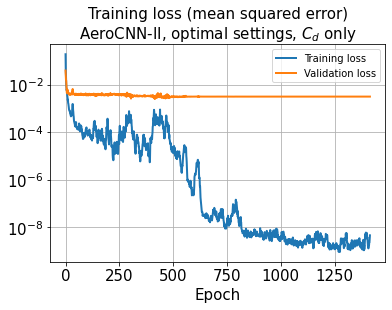

In [32]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-II, optimal settings, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

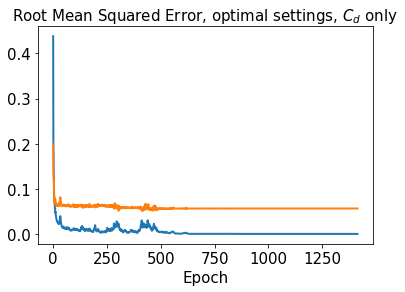

In [33]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

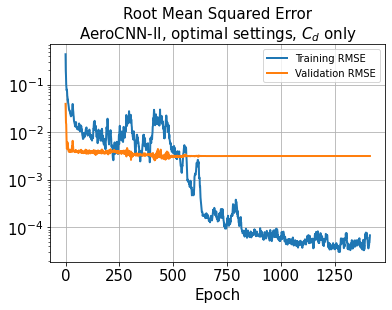

In [34]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-II, optimal settings, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [35]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 24ms/step - loss: 2.8535e-04 - rmse: 0.0169


In [36]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 91ms/step - loss: 0.0012 - rmse: 0.0352


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

1/1 [==============================] - 0s 15ms/step


In [38]:
index_train = np.unique(np.where(np.isin(cd, y_train)))
index_val = np.unique(np.where(np.isin(cd, y_val)))
index_test = np.unique(np.where(np.isin(cd, y_test)))

In [39]:
y_train = y_train*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
y_val = y_val*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
y_test = y_test*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)

In [40]:
decoded_train = decoded_train_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
decoded_val = decoded_val_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
decoded_test = decoded_test_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)

In [41]:
model_directory = "D:\\TrainedModels\\20221205"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221205steadyValidation_AeroCNN2_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels) +"units_optimalSettings_Cdonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [42]:
error_train_abs = np.abs(decoded_train - y_train)

In [43]:
error_test_abs = np.abs(decoded_test - y_test)

In [44]:
os.chdir(storage_dir)

In [45]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.033930617333611614


In [46]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.108886958671776


In [47]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.08203220999606362


In [48]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [49]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum((y_val[i]+1e-07)**2))
    l2_error_val_list.append(l2_error_val_data)

In [50]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

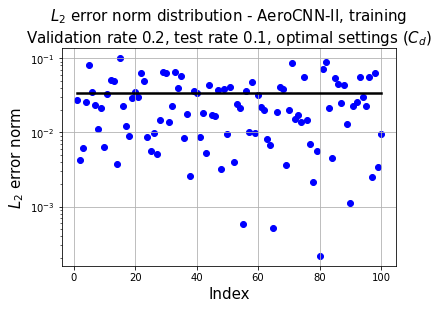

In [51]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

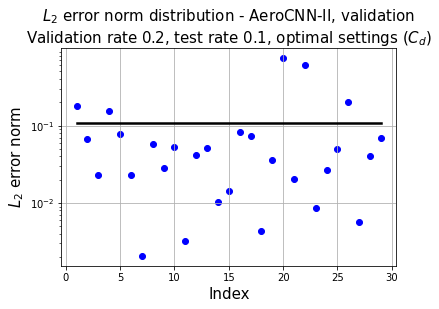

In [52]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, validation\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

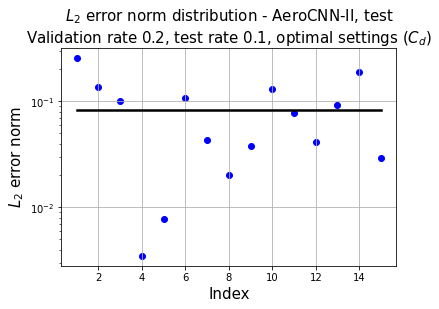

In [53]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [54]:
predicted = model.predict(x)

5/5 [==============================] - 0s 52ms/step


In [55]:
def CD_trainTestSplit_Plot(i, CD, cd, aTrain, aTest, iTrain, iTest):
    
    title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    #title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl
    
    title_n_Cd = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_D$ prediction, L2 error=%.4f'%(l2_error_Cd)
    #title_n_Cl = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_L$ prediction, L2 error=%.4f'%(l2_error_Cl)
    
    if i==0:
#         title_Cd, title_Cl = title_0_Cd, title_0_Cl
#         savename1,savename2 = "CdComparison_NACA0018.jpg", "ClComparison_NACA0018.jpg"
        title_Cd = title_0_Cd
        savename1 = "CdComparison_NACA0018.jpg"
    else:
#         title_Cd, title_Cl = title_n_Cd, title_n_Cl
        title_Cd = title_n_Cd
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
#         savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

    '''# CL graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig), color='b', label='Training set')
    plt.scatter(aTest, iTest[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()'''

1/1 [==============================] - 0s 82ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cd: 0.0994


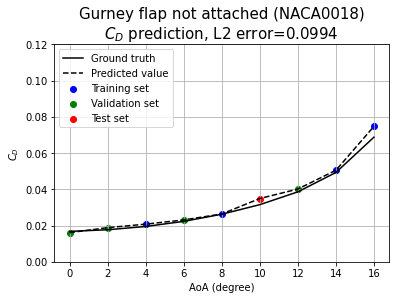

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0795


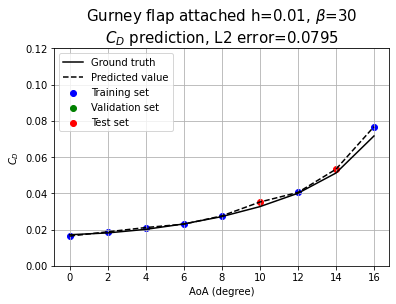

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0606


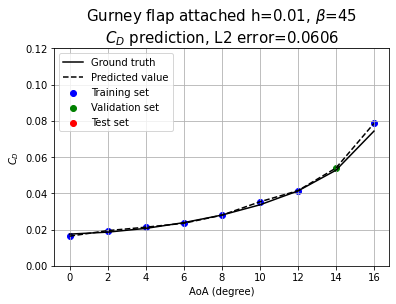

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0570


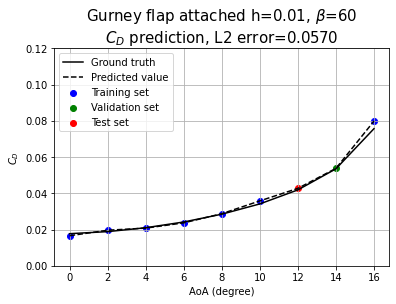

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0672


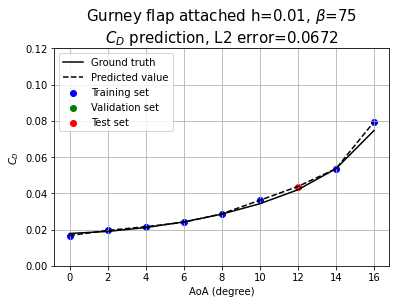

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0217


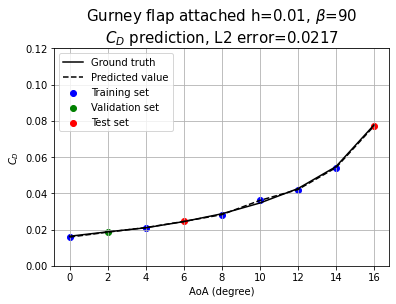

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0306


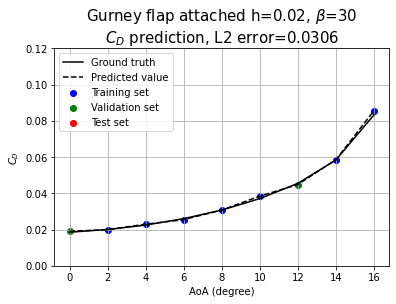

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0376


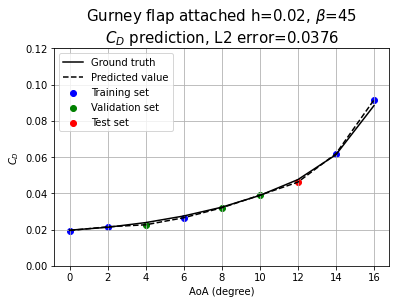

1/1 [==============================] - 0s 17ms/step
L2 error of Cd: 0.0251


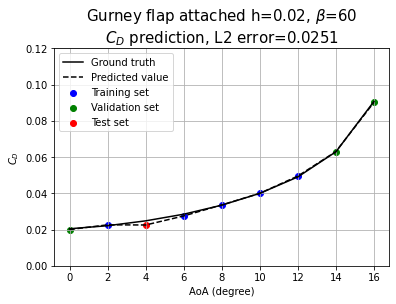

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0635


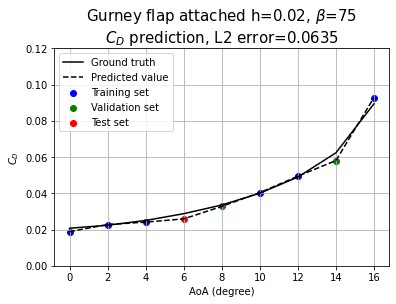

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.1509


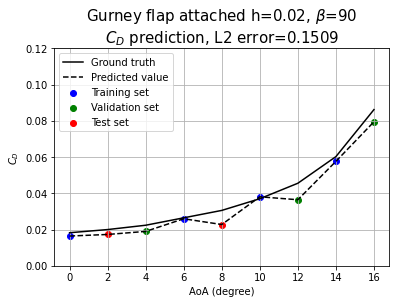

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0287


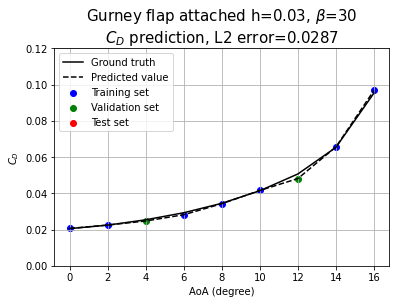

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0445


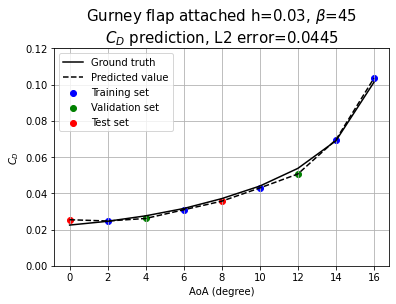

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0385


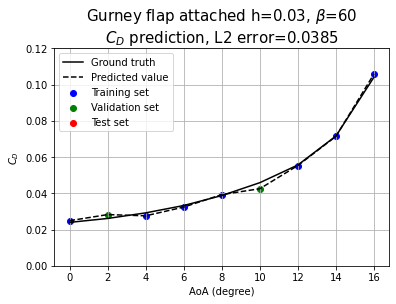

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0739


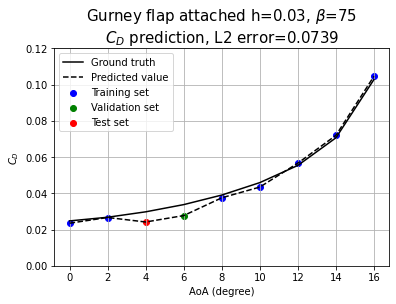

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.2892


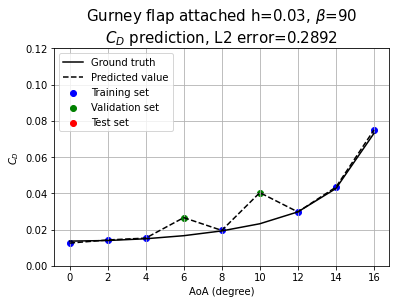

In [56]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    predictedValue = model.predict(x[n_alpha*i:n_alpha*(i+1),:])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cd = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}'.format(l2_error_Cd))
    else:
        print('L2 error of Cd: {0:0.4f}'.format(l2_error_Cd))
    
    cd = predicted[n_alpha*i:n_alpha*(i+1)]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    CD = y[n_alpha*i:n_alpha*(i+1)]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal.append(predicted[index])    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    iTest = np.array(iTest)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    iVal = np.array(iVal)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)*np.max(alpha)
    aVal = np.array(alpha_val)*np.max(alpha)
    aTest = np.array(alpha_test)*np.max(alpha)
    
    CD_trainTestSplit_Plot(i, CD, cd, aTrain, aTest, iTrain, iTest)